<a href="https://colab.research.google.com/github/Anjusharma05/PRODIGY_DS_04/blob/main/Task4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import re

train_df = pd.read_csv('/content/twitter_training.csv', header=None)
val_df = pd.read_csv('/content/twitter_validation.csv', header=None)

train_df.columns = ['tweet_id', 'entity', 'sentiment', 'content']
val_df.columns = ['tweet_id', 'entity', 'sentiment', 'content']

print("Training data shape:", train_df.shape)
print("Sample rows:\n", train_df.head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Training data shape: (74682, 4)
Sample rows:
    tweet_id       entity sentiment  \
0      2401  Borderlands  Positive   
1      2401  Borderlands  Positive   
2      2401  Borderlands  Positive   
3      2401  Borderlands  Positive   
4      2401  Borderlands  Positive   

                                             content  
0  im getting on borderlands and i will murder yo...  
1  I am coming to the borders and I will kill you...  
2  im getting on borderlands and i will kill you ...  
3  im coming on borderlands and i will murder you...  
4  im getting on borderlands 2 and i will murder ...  


In [ ]:
import nltk
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def clean_text(text):
    if pd.isnull(text):
        return ""
    text = str(text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+|\#', '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = text.lower()
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text


train_df['clean_text'] = train_df['content'].apply(clean_text)
val_df['clean_text'] = val_df['content'].apply(clean_text)

print("✅ Cleaning done successfully!")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✅ Cleaning done successfully!


/tmp/ipython-input-11-252378042.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x='sentiment', palette='Set2')


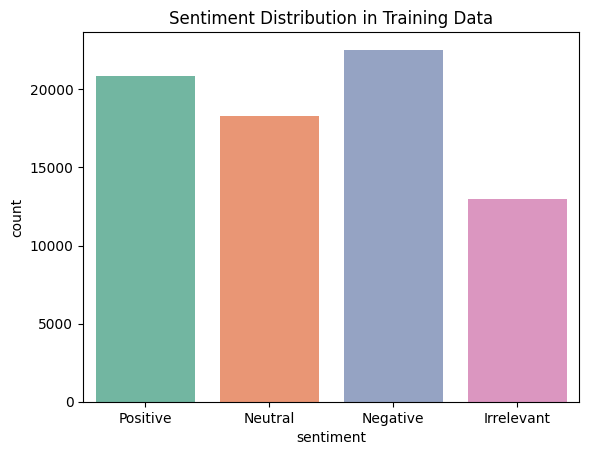

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=train_df, x='sentiment', palette='Set2')
plt.title('Sentiment Distribution in Training Data')
plt.show()


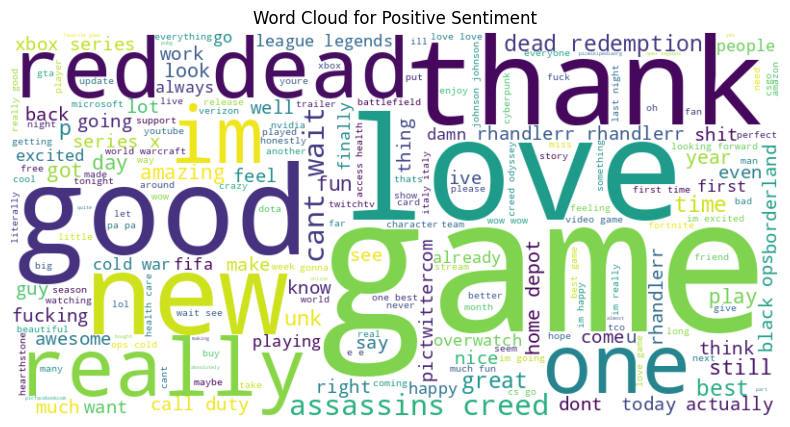

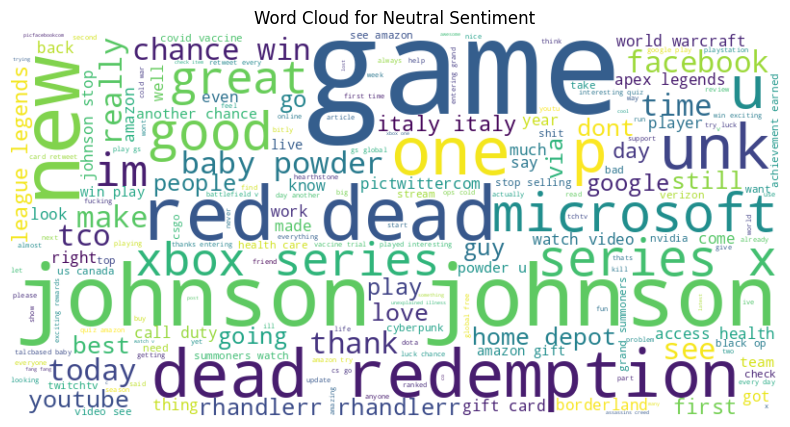

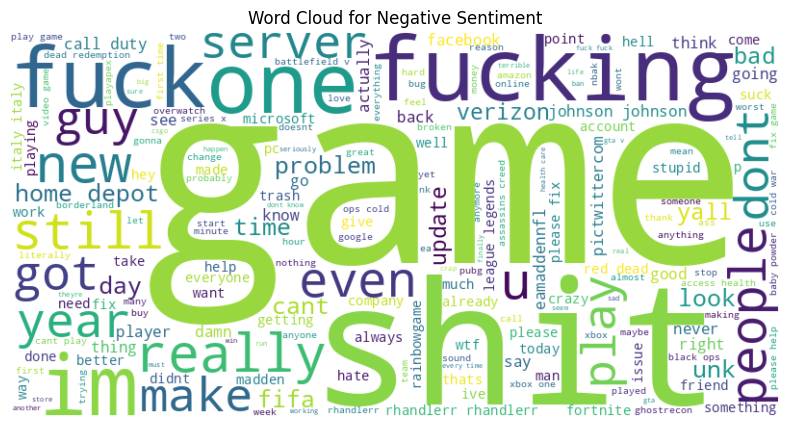

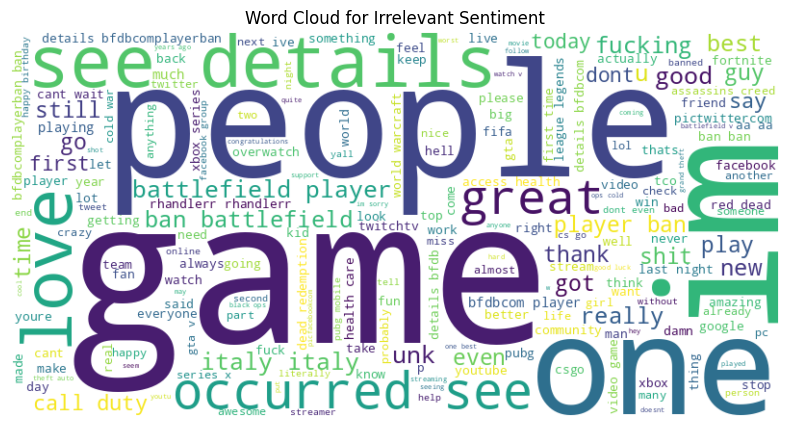

In [ ]:
from wordcloud import WordCloud

for sentiment in train_df['sentiment'].unique():
    text = ' '.join(train_df[train_df['sentiment'] == sentiment]['clean_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {sentiment} Sentiment')
    plt.show()


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_df['clean_text'])
X_val = vectorizer.transform(val_df['clean_text'])

y_train = train_df['sentiment']
y_val = val_df['sentiment']

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

print("Validation Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))


Validation Accuracy: 0.802

Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.80      0.66      0.72       172
    Negative       0.76      0.87      0.81       266
     Neutral       0.84      0.77      0.80       285
    Positive       0.82      0.86      0.84       277

    accuracy                           0.80      1000
   macro avg       0.80      0.79      0.79      1000
weighted avg       0.80      0.80      0.80      1000



In [ ]:
import pandas as pd

entity_sentiment_counts = train_df.groupby(['entity', 'sentiment']).size().unstack(fill_value=0)

# Preview
print(entity_sentiment_counts.head())


sentiment       Irrelevant  Negative  Neutral  Positive
entity                                                 
Amazon                 192       576     1236       312
ApexLegends            192       600      942       642
AssassinsCreed         264       378      156      1446
Battlefield            918       474      360       594
Borderlands            240       426      600      1020


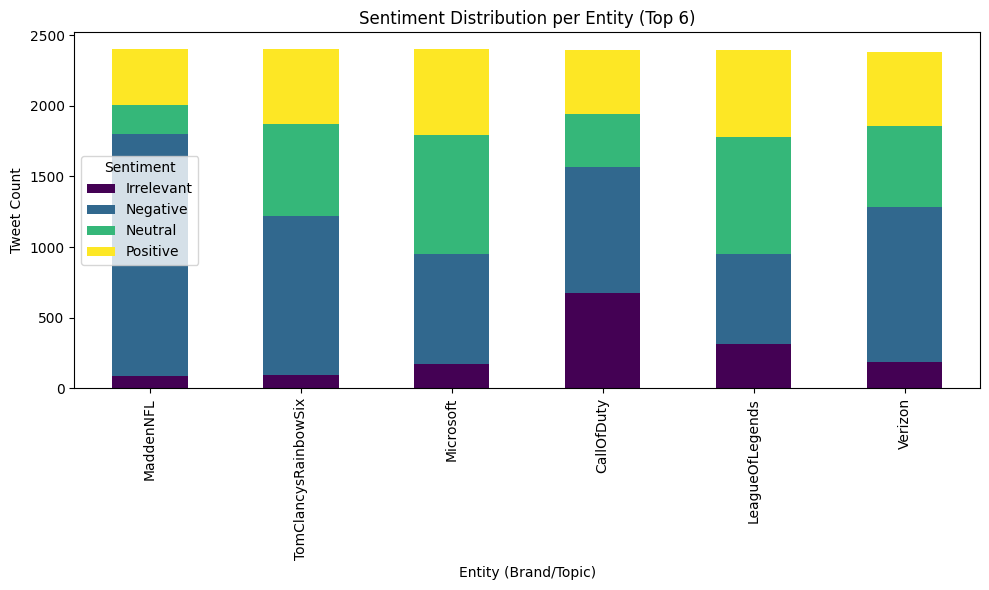

In [ ]:
import matplotlib.pyplot as plt

top_entities = entity_sentiment_counts.sum(axis=1).sort_values(ascending=False).head(6).index
subset = entity_sentiment_counts.loc[top_entities]

subset.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('Sentiment Distribution per Entity (Top 6)')
plt.xlabel('Entity (Brand/Topic)')
plt.ylabel('Tweet Count')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()


                Irrelevant_actual  Negative_actual  Neutral_actual  \
entity                                                               
Amazon                          3                6              18   
ApexLegends                     3                6              17   
AssassinsCreed                  1                4               4   
Battlefield                    12                7               4   
Borderlands                     2                5              12   

                Positive_actual  Irrelevant_predicted  Negative_predicted  \
entity                                                                      
Amazon                        7                     2                   5   
ApexLegends                  10                     5                   8   
AssassinsCreed               24                     2                   3   
Battlefield                   3                     8                   7   
Borderlands                  14                

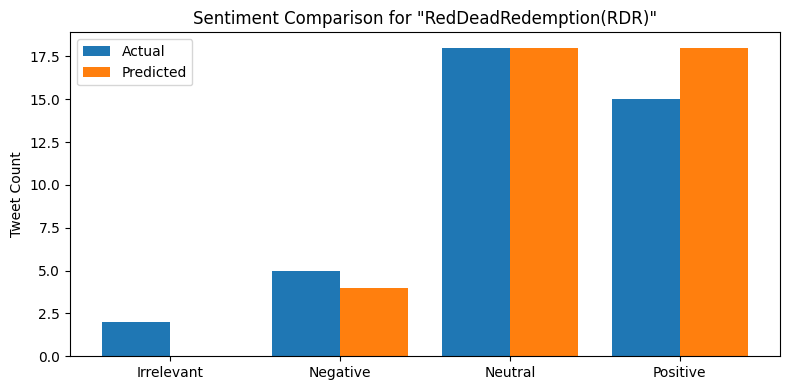

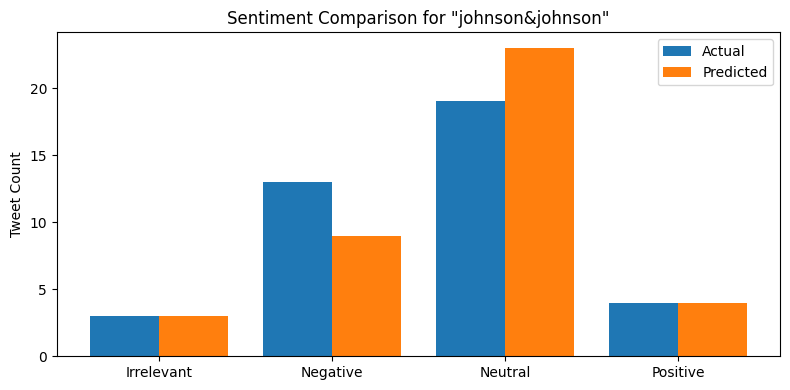

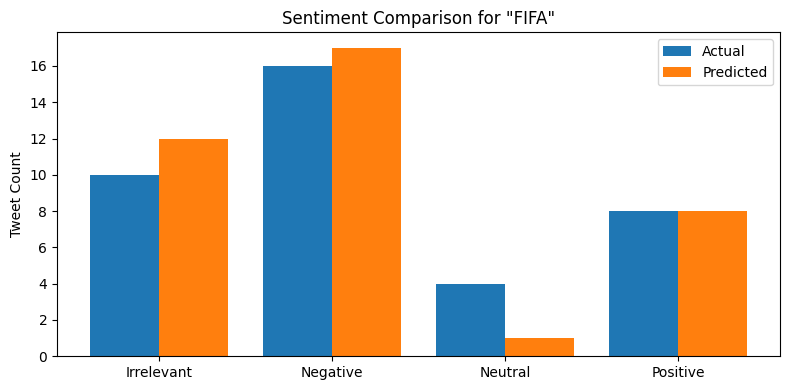

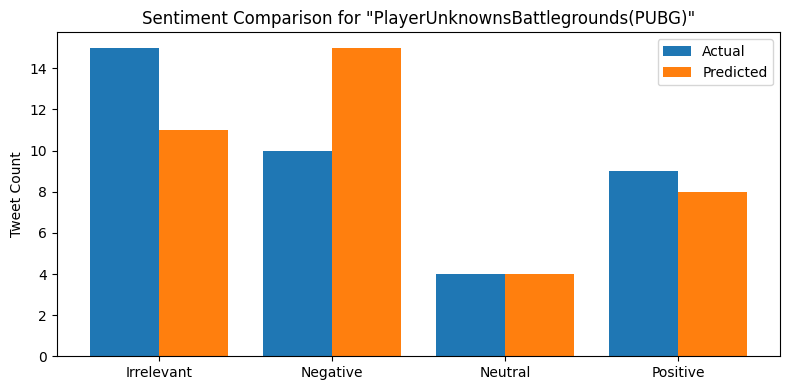

In [ ]:
val_df['predicted_sentiment'] = y_pred
actual_counts = val_df.groupby(['entity', 'sentiment']).size().unstack(fill_value=0)

predicted_counts = val_df.groupby(['entity', 'predicted_sentiment']).size().unstack(fill_value=0)

comparison = actual_counts.add_suffix('_actual').join(predicted_counts.add_suffix('_predicted'))

print(comparison.head())

top_entities = comparison.sum(axis=1).sort_values(ascending=False).head(4).index

for entity in top_entities:
    entity_data = comparison.loc[entity]

    sentiments = [col.replace('_actual', '') for col in entity_data.index if '_actual' in col]
    actual = [entity_data[s + '_actual'] for s in sentiments]
    predicted = [entity_data[s + '_predicted'] for s in sentiments]

    x = range(len(sentiments))
    plt.figure(figsize=(8, 4))
    plt.bar(x, actual, width=0.4, label='Actual', align='center')
    plt.bar([i + 0.4 for i in x], predicted, width=0.4, label='Predicted', align='center')
    plt.xticks([i + 0.2 for i in x], sentiments)
    plt.title(f'Sentiment Comparison for "{entity}"')
    plt.ylabel('Tweet Count')
    plt.legend()
    plt.tight_layout()
    plt.show()


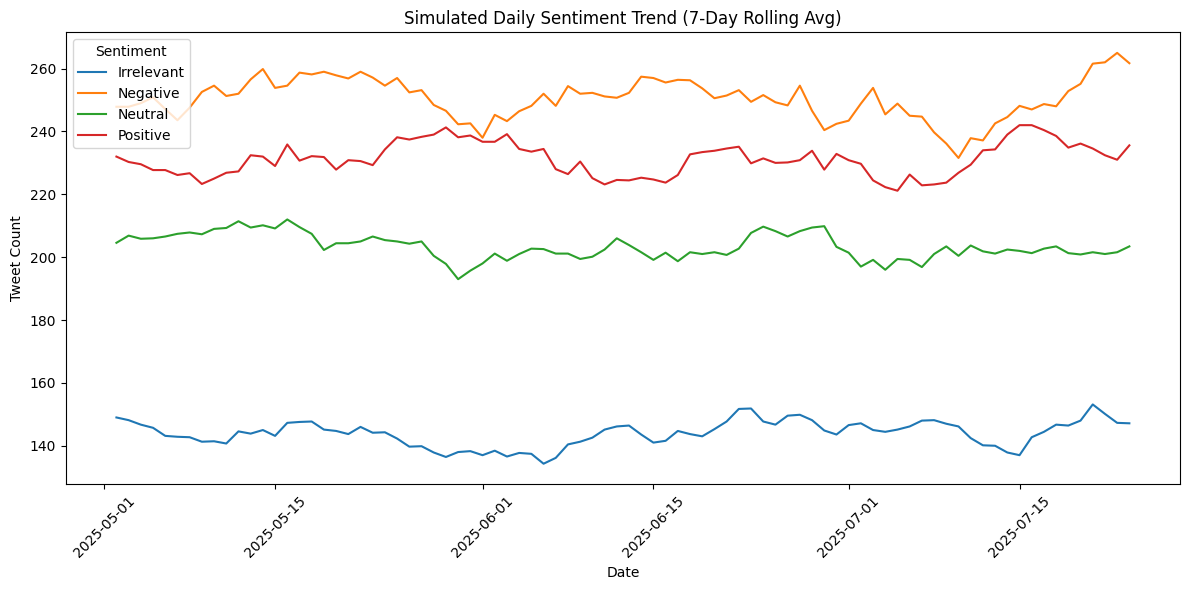

In [ ]:
import numpy as np
from datetime import datetime, timedelta

np.random.seed(42)

start_date = datetime.today() - timedelta(days=90)
random_days = np.random.randint(0, 90, size=len(train_df))
train_df['date'] = [start_date + timedelta(days=int(d)) for d in random_days]

train_df['date'] = pd.to_datetime(train_df['date'])
daily_sentiment = train_df.groupby([train_df['date'].dt.date, 'sentiment']).size().unstack(fill_value=0)

daily_sentiment_rolling = daily_sentiment.rolling(window=7).mean()
plt.figure(figsize=(12, 6))
for sentiment in daily_sentiment.columns:
    plt.plot(daily_sentiment_rolling.index, daily_sentiment_rolling[sentiment], label=sentiment)

plt.title('Simulated Daily Sentiment Trend (7-Day Rolling Avg)')
plt.xlabel('Date')
plt.ylabel('Tweet Count')
plt.legend(title='Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
